In [20]:
# --- 1. 导入必要的库 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math

# 设置绘图风格
sns.set(style="whitegrid")

In [21]:
# --- 2. 加载处理后的数据 (v1.0) ---
data_path = '../data/raw_data_1.0.csv'

print(f"--- 正在加载 v1.0 数据 ---")
print(f"文件路径: '{data_path}'")

data_path_v2 = '../data/raw_data_2.0.csv'

print(f"--- 正在加载 v2.0 (PCTL_BNT 清洗后) 的数据 ---")
df_v2 = pd.read_csv(data_path_v2)

try:
    df = pd.read_csv(data_path)
    print("\n数据加载成功！")
except FileNotFoundError:
    print(f"\n错误: 数据文件未找到 at '{data_path}'")
    print("请确认你已经成功运行了 processing/process_main_dataset.py 和 processing/clean_pctl_bnt.py 脚本。")

--- 正在加载 v1.0 数据 ---
文件路径: '../data/raw_data_1.0.csv'
--- 正在加载 v2.0 (PCTL_BNT 清洗后) 的数据 ---

数据加载成功！


In [22]:
# --- 2.1. 重新优化数据类型 ---
print("检查可以从 float 转换为 integer 的列...")

cols_converted = []
for col in df.columns:
    # 只检查浮点类型的列
    if pd.api.types.is_float_dtype(df[col]):
        # 检查所有非空值是否都可以被视为整数
        if (df[col].dropna() % 1 == 0).all():
            # 使用可空的整数类型 'Int64' 来处理可能存在的 NaN 值
            df[col] = df[col].astype('Int64')
            cols_converted.append(col)

if cols_converted:
    print(f"\n成功转换了 {len(cols_converted)} 个列为 'int64':")
    # 为了简洁，我们只打印前几个
    print(sorted(cols_converted)[:10], "...")
else:
    print("\n没有列需要转换。")

print("\n--- 优化后的数据类型 ---")
df.info()


检查可以从 float 转换为 integer 的列...

成功转换了 42 个列为 'int64':
['DVS_BNT', 'DVS_FAS', 'DVS_JLO_MSSA', 'DVS_LNS', 'DVS_SFTANIM', 'DVT_DELAYED_RECALL', 'DVT_FAS', 'DVT_RECOG_DISC_INDEX', 'DVT_RETENTION', 'DVT_SFTANIM'] ...

--- 优化后的数据类型 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15316 entries, 0 to 15315
Data columns (total 59 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PATNO                 15316 non-null  int64  
 1   EVENT_ID              15316 non-null  object 
 2   NP1DPRS               15255 non-null  Int64  
 3   ptau                  4355 non-null   float64
 4   hvlt_discrimination   14577 non-null  Int64  
 5   SDMTOTAL              14584 non-null  Int64  
 6   DVT_SFTANIM           14601 non-null  Int64  
 7   orthostasis           14571 non-null  Int64  
 8   lexical               8106 non-null   Int64  
 9   upsit                 5563 non-null   Int64  
 10  DVS_SFTANIM           14636 non-null  Int64  

In [23]:
# --- 3. 数据基本信息概览 ---
print("--- 数据基本信息 ---")
print(f"数据形状 (行, 列): {df.shape}\n")

print("--- 前20行数据 ---")
display(df.head(20))



--- 数据基本信息 ---
数据形状 (行, 列): (15316, 59)

--- 前20行数据 ---


,PATNO,EVENT_ID,NP1DPRS,ptau,hvlt_discrimination,SDMTOTAL,DVT_SFTANIM,orthostasis,lexical,upsit,...,quip_walk,urate,upsit_pctl15,stai,stai_state,TMT_B,MSEADLG,MODBNT,DVT_RECOG_DISC_INDEX,COHORT
0,100001,BL,0,NaN,1,50,49,0,32,27,...,0,3.7,0,48,27,87,90,58,20,1
1,100001,V04,0,NaN,9,50,53,0,38,<NA>,...,0,NaN,<NA>,58,32,59,95,56,42,1
2,100001,V06,0,NaN,11,44,57,0,29,<NA>,...,0,NaN,<NA>,86,58,73,95,57,50,1
3,100001,V08,0,NaN,7,49,43,0,40,<NA>,...,0,NaN,<NA>,54,25,97,95,58,31,1
4,100001,V10,0,NaN,9,28,51,0,44,<NA>,...,0,NaN,<NA>,47,25,106,90,56,38,1
5,100002,BL,0,NaN,7,37,45,0,28,<NA>,...,0,5.9,<NA>,60,32,60,95,57,20,1
6,100002,V04,0,NaN,10,32,45,0,29,<NA>,...,0,NaN,<NA>,58,26,70,95,56,44,1
7,100002,V06,0,NaN,9,42,35,0,34,<NA>,...,0,NaN,<NA>,41,20,58,95,57,33,1
8,100002,V08,0,NaN,7,36,53,0,42,<NA>,...,0,NaN,<NA>,51,27,97,90,58,20,1
9,100002,V10,0,NaN,10,27,49,1,30,<NA>,...,0,NaN,<NA>,45,22,70,100,58,41,1


In [24]:
# --- 3.1. 特征类型分析 ---
import json

print("--- 特征类型分析 ---")

# 加载预期的值范围
expected_ranges_path = '../data/expected_value_range.json'
try:
    with open(expected_ranges_path, 'r') as f:
        expected_ranges = json.load(f)
except FileNotFoundError:
    print(f"警告: 预期值范围文件未找到 at '{expected_ranges_path}'")
    expected_ranges = {}

# 存储分析结果
feature_analysis = []

# 遍历所有列
for col in df.columns:
    # 获取基本信息
    dtype = df[col].dtype
    unique_count = df[col].nunique()
    
    # 初始化额外信息
    value_range = 'N/A' # 非数值列的默认值
    mean_val = 'N/A'
    std_dev = 'N/A'

    # 推断特征类型并计算范围
    if col == 'COHORT':
        feature_type = '预测目标 (Target)'
    elif col == 'PATNO':
        feature_type = '标识符 (Identifier)'
    elif dtype == 'object':
        feature_type = '字符型/分类 (Categorical-String)'
    elif pd.api.types.is_numeric_dtype(dtype):
        # 如果列中没有有效值，min/max会报错，需要处理
        if not df[col].dropna().empty:
            min_val = df[col].min()
            max_val = df[col].max()
            value_range = f"{min_val:.2f} - {max_val:.2f}"
            # 计算均值和标准差
            mean_val = f"{df[col].mean():.2f}"
            std_dev = f"{df[col].std():.2f}"
        else:
            value_range = 'All NaN'
            mean_val = 'All NaN'
            std_dev = 'All NaN'

        # 对数值类型进行更细的区分
        if unique_count == 2:
            feature_type = '数值型/二元分类 (Numerical-Binary)'
        elif unique_count < 25:
            feature_type = '数值型/分类 (Numerical-Categorical)'
        else:
            feature_type = '数值型/连续 (Numerical-Continuous)'
    else:
        feature_type = '其他 (Other)'

    # 获取预期的范围
    expected_range_str = expected_ranges.get(col, {}).get('range_str', 'N/A')
        
    feature_analysis.append({
        '特征 (Feature)': col,
        '数据类型 (Dtype)': dtype,
        '唯一值数量 (Unique Values)': unique_count,
        '取值范围 (Value Range)': value_range,
        '预期取值范围 (Expected Range)': expected_range_str,
        '均值 (Mean)': mean_val,
        '标准差 (Std Dev)': std_dev,
        '特征类型 (Inferred Type)': feature_type
    })

# 转换为DataFrame并以表格形式显示
analysis_df = pd.DataFrame(feature_analysis)

# 重新排列列的顺序
desired_order = [
    '特征 (Feature)', 
    '特征类型 (Inferred Type)',
    '数据类型 (Dtype)', 
    '唯一值数量 (Unique Values)', 
    '取值范围 (Value Range)', 
    '预期取值范围 (Expected Range)',
    '均值 (Mean)', 
    '标准差 (Std Dev)'
]
analysis_df = analysis_df[desired_order]


with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # 显示所有行
    display(analysis_df)

print("\n分析: 上表总结了每个特征的数据类型、推断用途及其取值范围。")
print("通过对比'取值范围'和'预期取值范围'，我们可以快速识别出数据中可能存在的异常值或与预期不符的分布。")


--- 特征类型分析 ---


,特征 (Feature),特征类型 (Inferred Type),数据类型 (Dtype),唯一值数量 (Unique Values),取值范围 (Value Range),预期取值范围 (Expected Range),均值 (Mean),标准差 (Std Dev)
0,PATNO,标识符 (Identifier),int64,4035,N/A,N/A,N/A,N/A
1,EVENT_ID,字符型/分类 (Categorical-String),object,17,N/A,N/A,N/A,N/A
2,NP1DPRS,数值型/分类 (Numerical-Categorical),Int64,5,0.00 - 4.00,0 - 4,0.36,0.72
3,ptau,数值型/连续 (Numerical-Continuous),float64,1732,8.00 - 80.54,8 - 100,15.70,6.60
4,hvlt_discrimination,数值型/分类 (Numerical-Categorical),Int64,20,-5.00 - 24.00,-5 - 24,10.21,2.23
5,SDMTOTAL,数值型/连续 (Numerical-Continuous),Int64,94,0.00 - 102.00,0 - 110,43.06,11.99
6,DVT_SFTANIM,数值型/连续 (Numerical-Continuous),Int64,82,8.00 - 90.00,0 - 100,52.23,11.03
7,orthostasis,数值型/二元分类 (Numerical-Binary),Int64,2,0.00 - 1.00,"0, 1",0.14,0.35
8,lexical,数值型/连续 (Numerical-Continuous),Int64,100,3.00 - 111.00,无理论上限,44.09,13.91
9,upsit,数值型/连续 (Numerical-Continuous),Int64,41,0.00 - 40.00,0 - 40,24.26,8.77



分析: 上表总结了每个特征的数据类型、推断用途及其取值范围。
通过对比'取值范围'和'预期取值范围'，我们可以快速识别出数据中可能存在的异常值或与预期不符的分布。


--- 缺失值分析 ---
缺失值情况



,Missing Count,Missing Percentage
abeta,11146,72.773570
ptau,10961,71.565683
tau,10722,70.005223
upsit,9753,63.678506
upsit_pctl,9753,63.678506
upsit_pctl15,9740,63.593628
urate,7958,51.958736
age_datscan,7923,51.730217
PCTL_BNT,7701,50.280752
DVS_BNT,7701,50.280752


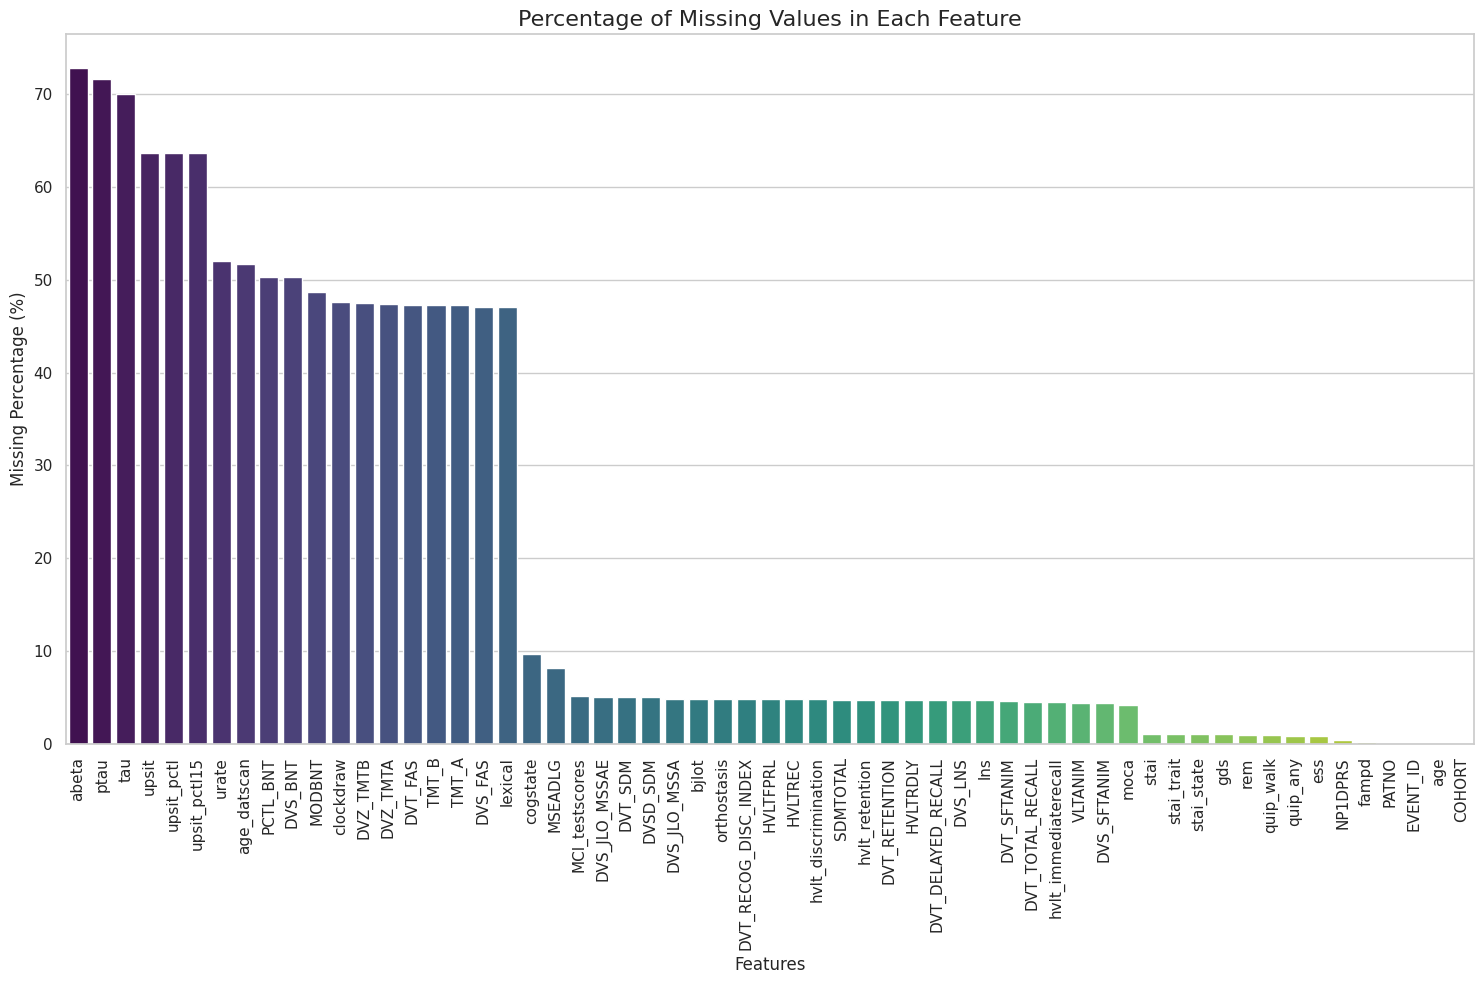

In [25]:
# --- 4. 缺失值分析 ---
print("--- 缺失值分析 ---")

# 计算每个特征的缺失值数量和比例
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# 创建一个包含缺失值信息的新DataFrame，并按比例降序排列
missing_info = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percentage
}).sort_values(by='Missing Percentage', ascending=False)

# 过滤掉没有缺失值的特征
missing_info = missing_info[missing_info['Missing Count'] >= 0]

print(f"缺失值情况\n")
display(missing_info)

# 可视化缺失值比例
plt.figure(figsize=(15, 10))
sns.barplot(x=missing_info.index, y=missing_info['Missing Percentage'], hue=missing_info.index, palette='viridis', legend=False)
plt.title('Percentage of Missing Values in Each Feature', fontsize=16)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Missing Percentage (%)', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



--- 目标变量 COHORT 分布分析 ---
COHORT 类别分布:
  - 类别 1: 7021 条记录 (45.84%)
  - 类别 4: 6136 条记录 (40.06%)
  - 类别 2: 1960 条记录 (12.80%)
  - 类别 3: 199 条记录 (1.30%)


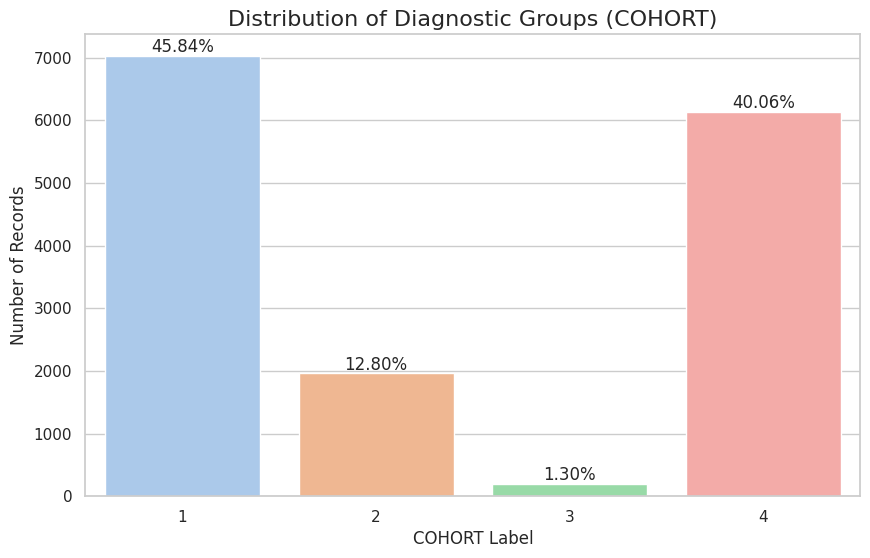

In [26]:
# --- 6. 目标变量 (COHORT) 分布分析 ---
print("--- 目标变量 COHORT 分布分析 ---")

# 计算每个类别的数量和比例
cohort_counts = df['COHORT'].value_counts()
cohort_percentages = df['COHORT'].value_counts(normalize=True) * 100

# 打印结果
print("COHORT 类别分布:")
for cohort_id, count in cohort_counts.items():
    print(f"  - 类别 {cohort_id}: {count} 条记录 ({cohort_percentages[cohort_id]:.2f}%)")

# 可视化类别分布
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='COHORT', data=df, hue='COHORT', palette='pastel', legend=False)
plt.title('Distribution of Diagnostic Groups (COHORT)', fontsize=16)
plt.xlabel('COHORT Label', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)

# 在每个条形上显示百分比
for p in ax.patches:
    percentage = f'{100 * p.get_height() / len(df):.2f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()



--- Object 类型特征分析 ---

--- 分析 EVENT_ID ---
EVENT_ID 共有 17 个唯一值。
最常见的10个 EVENT_ID 值:
EVENT_ID
BL     4035
V04    2894
V06    1816
V08    1270
V10    1056
V12     993
V13     722
V14     700
V15     489
V17     350
Name: count, dtype: int64


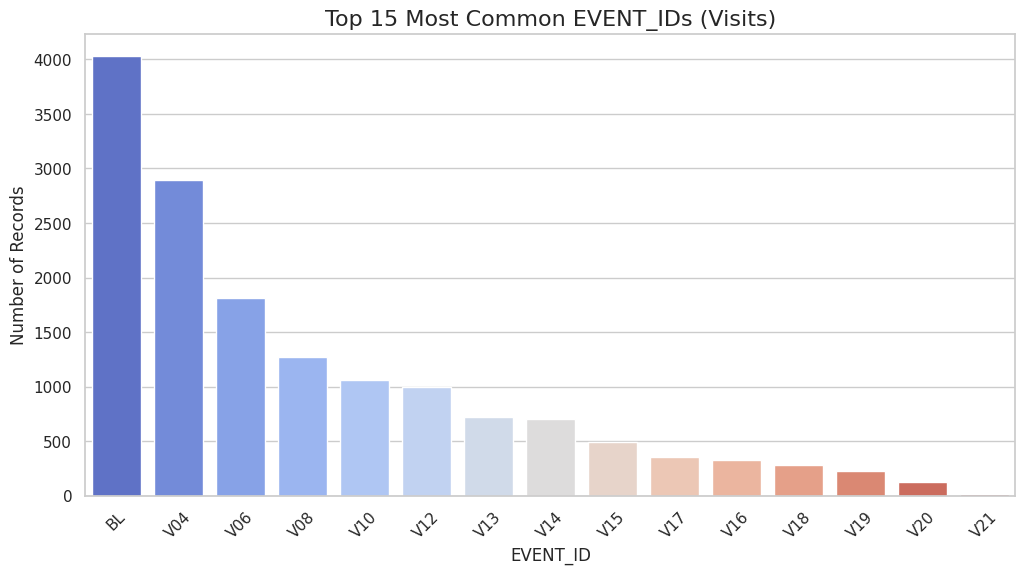

In [27]:
# --- 6. Object 类型特征分析 ---
print("--- Object 类型特征分析 ---")

# 分析 EVENT_ID
print("\n--- 分析 EVENT_ID ---")
event_id_counts = df['EVENT_ID'].value_counts()
print(f"EVENT_ID 共有 {len(event_id_counts)} 个唯一值。")
print("最常见的10个 EVENT_ID 值:")
print(event_id_counts.head(10))

# 可视化 EVENT_ID 分布
plt.figure(figsize=(12, 6))
sns.barplot(x=event_id_counts.head(15).index, y=event_id_counts.head(15).values, hue=event_id_counts.head(15).index, palette='coolwarm', legend=False)
plt.title('Top 15 Most Common EVENT_IDs (Visits)', fontsize=16)
plt.xlabel('EVENT_ID', fontsize=12)
plt.ylabel('Number of Records', fontsize=12)
plt.xticks(rotation=45)
plt.show()




In [28]:
# --- 6.1. 查看 PCTL_BNT 的所有唯一值 ---
print("--- 'PCTL_BNT' 列的所有唯一取值 ---")

# 使用 .dropna().unique() 来获取所有非空的唯一值
pctl_bnt_all_unique_values = df['PCTL_BNT'].dropna().unique()

# 打印结果
print(f"共找到 {len(pctl_bnt_all_unique_values)} 个唯一的非空值:")
for value in pctl_bnt_all_unique_values:
    print(f"- {value}")

--- 'PCTL_BNT' 列的所有唯一取值 ---
共找到 15 个唯一的非空值:
- 41 to 59
- 29 to 40
- 72 to 81
- 19 to 28
- 82 to 89
- 90 to 94
- 60 to 71
- 99
- 3 to 5
- 11 to 18
- 95 to 97
- 6 to 10
- 2
- 1
- <1


In [29]:
# --- 6.2. 加载并验证 PCTL_BNT 清洗后的数据 ---
# 注意：我们假设 clean_pctl_bnt.py 脚本已运行，并生成了 'raw_data_2.0.csv'
data_path_v2 = '../data/raw_data_2.0.csv'

print(f"--- 正在加载 v2.0 (PCTL_BNT 清洗后) 的数据 ---")
print(f"文件路径: '{data_path_v2}'")
# 加载到新的 DataFrame 以便对比
df_v2 = pd.read_csv(data_path_v2)
print("\nv2.0 数据加载成功！")

pctl_bnt_all_unique_values = df_v2['PCTL_BNT'].dropna().unique()
# 额外验证 PCTL_BNT 列
print(f"共找到 {len(pctl_bnt_all_unique_values)} 个唯一的非空值:")
for value in pctl_bnt_all_unique_values:
    print(f"- {value}")



--- 正在加载 v2.0 (PCTL_BNT 清洗后) 的数据 ---
文件路径: '../data/raw_data_2.0.csv'

v2.0 数据加载成功！
共找到 15 个唯一的非空值:
- 50.0
- 34.5
- 76.5
- 23.5
- 85.5
- 92.0
- 65.5
- 99.0
- 4.0
- 14.5
- 96.0
- 8.0
- 2.0
- 1.0
- 0.0


In [30]:
# --- 5. 异常值分析 (IQR 方法) ---
print("--- 使用 IQR 方法进行异常值检测 ---")

# === 1. 从 analysis_features.json 加载数值特征列表 ===
with open('../data/analysis_features.json', 'r', encoding='utf-8') as f:
    analysis_features = json.load(f)

numeric_features_for_outliers = analysis_features.get('numerical_features', [])

# === 2. 确保这些特征存在于 df_v2 中 ===
numeric_features_for_outliers = [
    f for f in numeric_features_for_outliers if f in df_v2.columns
]

# === 3. 去掉 ID 和 目标列（防止干扰） ===
numeric_features_for_outliers = [
    col for col in numeric_features_for_outliers
    if col not in ['PATNO', 'COHORT']
]

# === 4. 创建结果列表 ===
outlier_summary = []

# === 5. 遍历所有数值特征，应用 IQR 方法 ===
for col in numeric_features_for_outliers:
    feature_data = df_v2[col].dropna()  # 去掉缺失值
    
    # 如果特征中没有数据，则跳过
    if feature_data.empty:
        continue
    
    # 计算 Q1, Q3, IQR
    Q1 = feature_data.quantile(0.25)
    Q3 = feature_data.quantile(0.75)
    IQR = Q3 - Q1
    
    # 定义异常值边界（这里使用 1.5 * IQR 比较常见）
    lower_bound = Q1 - 3 * IQR
    upper_bound = Q3 + 3 * IQR
    
    # 查找异常值
    outliers = feature_data[(feature_data < lower_bound) | (feature_data > upper_bound)]
    outlier_count = len(outliers)
    total_count = len(feature_data)
    outlier_ratio = outlier_count / total_count if total_count > 0 else np.nan
    
    # 存储结果
    outlier_summary.append({
        'Feature': col,
        'Q1': round(Q1, 2),
        'Q3': round(Q3, 2),
        'IQR': round(IQR, 2),
        'Lower Bound': round(lower_bound, 2),
        'Upper Bound': round(upper_bound, 2),
        'Outlier Count': outlier_count,
        'Total Count': total_count,
        'Outlier Ratio (%)': round(outlier_ratio * 100, 2)
    })

# === 6. 转为 DataFrame 并展示 ===
outlier_df = pd.DataFrame(outlier_summary)
outlier_df = outlier_df.sort_values(by='Outlier Ratio (%)', ascending=False)
outlier_df


--- 使用 IQR 方法进行异常值检测 ---


,Feature,Q1,Q3,IQR,Lower Bound,Upper Bound,Outlier Count,Total Count,Outlier Ratio (%)
24,TMT_B,57.00,105.00,48.00,-87.00,249.00,423,8075,5.24
19,MODBNT,56.00,60.00,4.00,44.00,72.00,262,7862,3.33
30,clockdraw,6.00,7.00,1.00,3.00,10.00,239,8032,2.98
18,HVLTREC,11.00,12.00,1.00,8.00,15.00,371,14577,2.55
23,TMT_A,26.00,44.00,18.00,-28.00,98.00,200,8084,2.47
20,MSEADLG,90.00,100.00,10.00,60.00,130.00,243,14060,1.73
39,ptau,11.36,18.21,6.86,-9.21,38.78,48,4355,1.10
32,gds,0.00,3.00,3.00,-9.00,12.00,152,15158,1.00
16,HVLTFPRL,0.00,1.00,1.00,-3.00,4.00,143,14577,0.98
44,tau,131.60,209.78,78.18,-102.93,444.30,35,4594,0.76


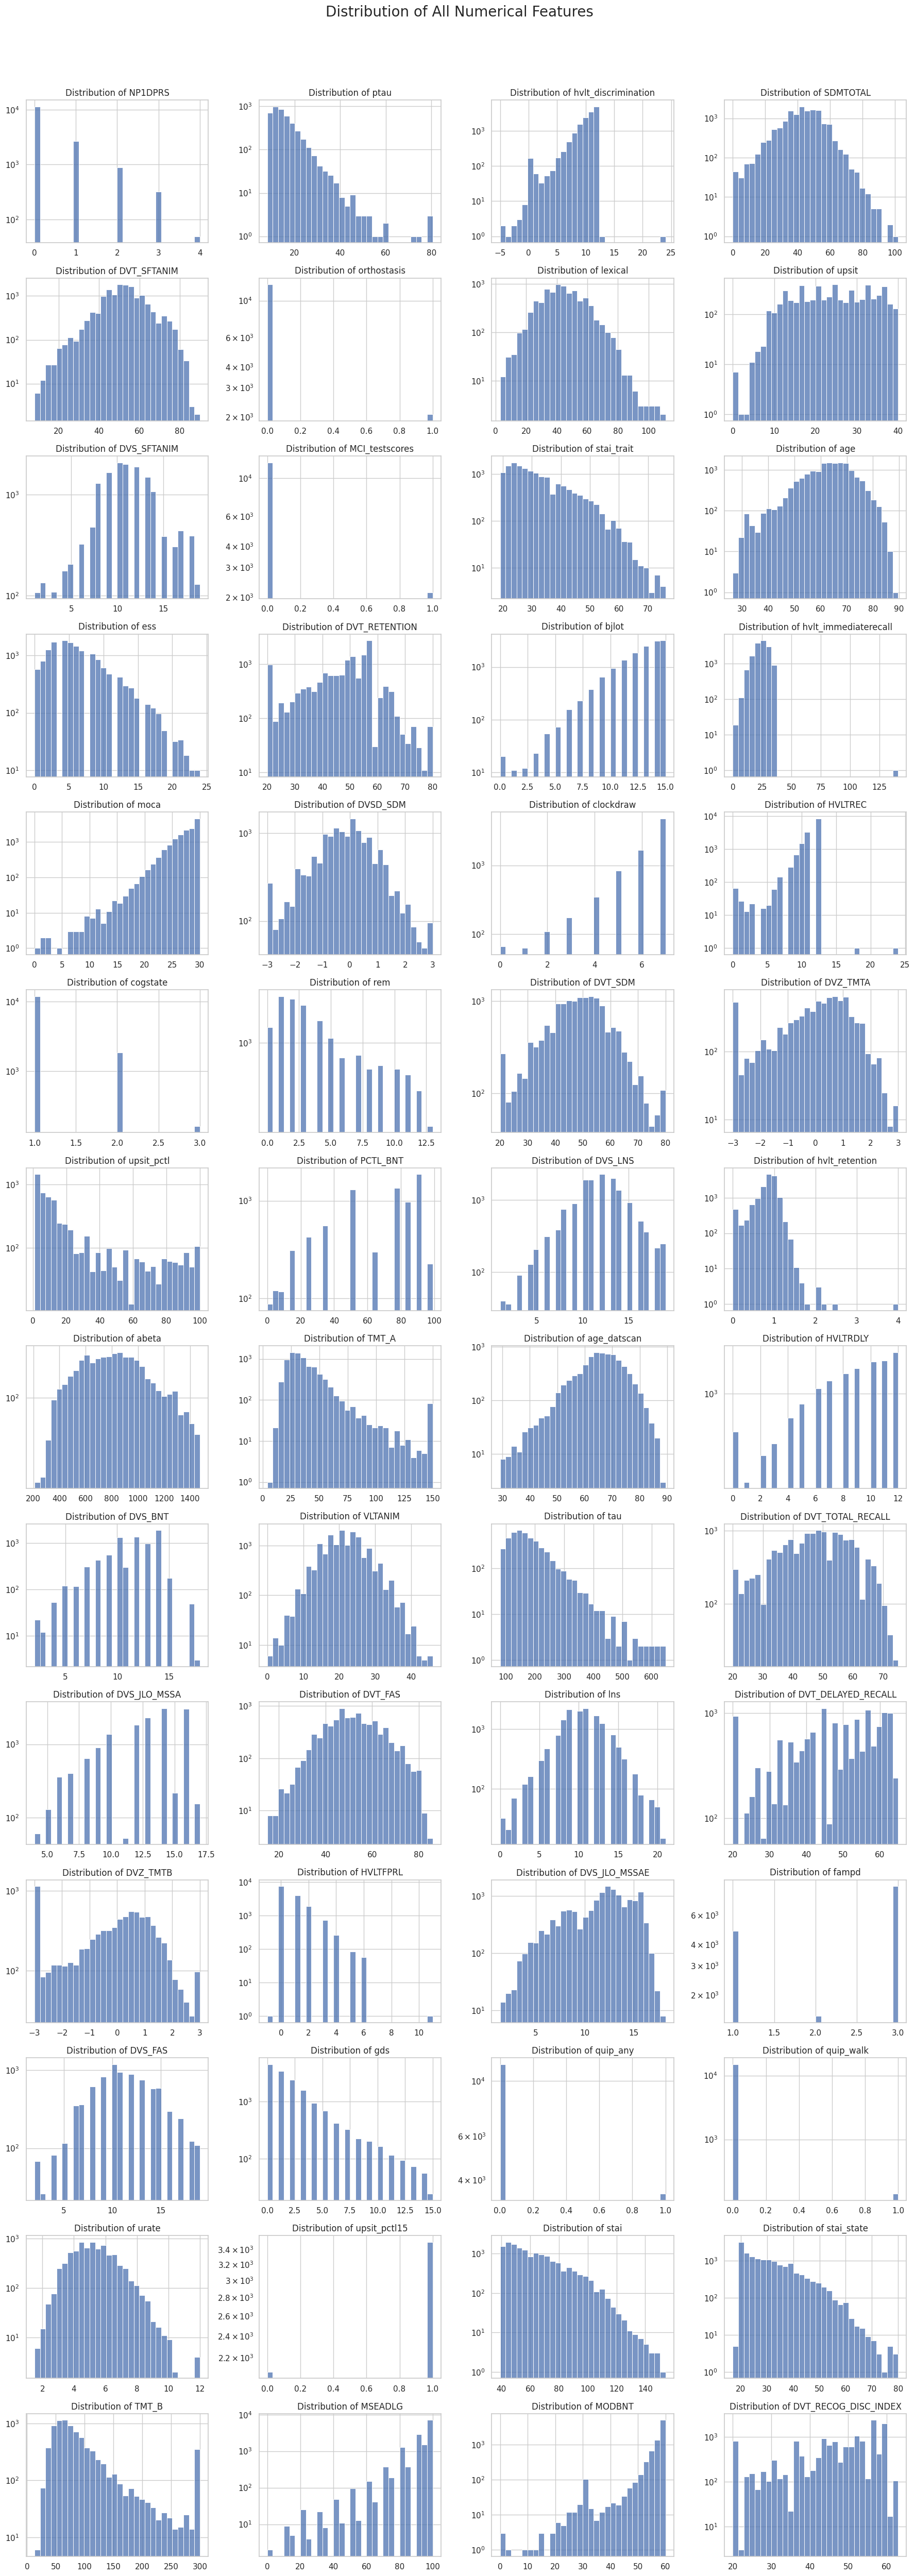

In [31]:
numeric_features = (
    df_v2.select_dtypes(include=np.number)
      .drop(columns=['PATNO', 'COHORT'])
      .columns
)

n_features = len(numeric_features)
n_cols = 4
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 3.5 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.histplot(df_v2[feature].dropna(), kde=False, ax=axes[i], bins=30)
    axes[i].set_yscale('log')
    axes[i].set_title(f'Distribution of {feature}', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle('Distribution of All Numerical Features', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


--- 绘制所有数值特征的箱线图（按 COHORT 分组） ---
检测到 56 个数值特征。


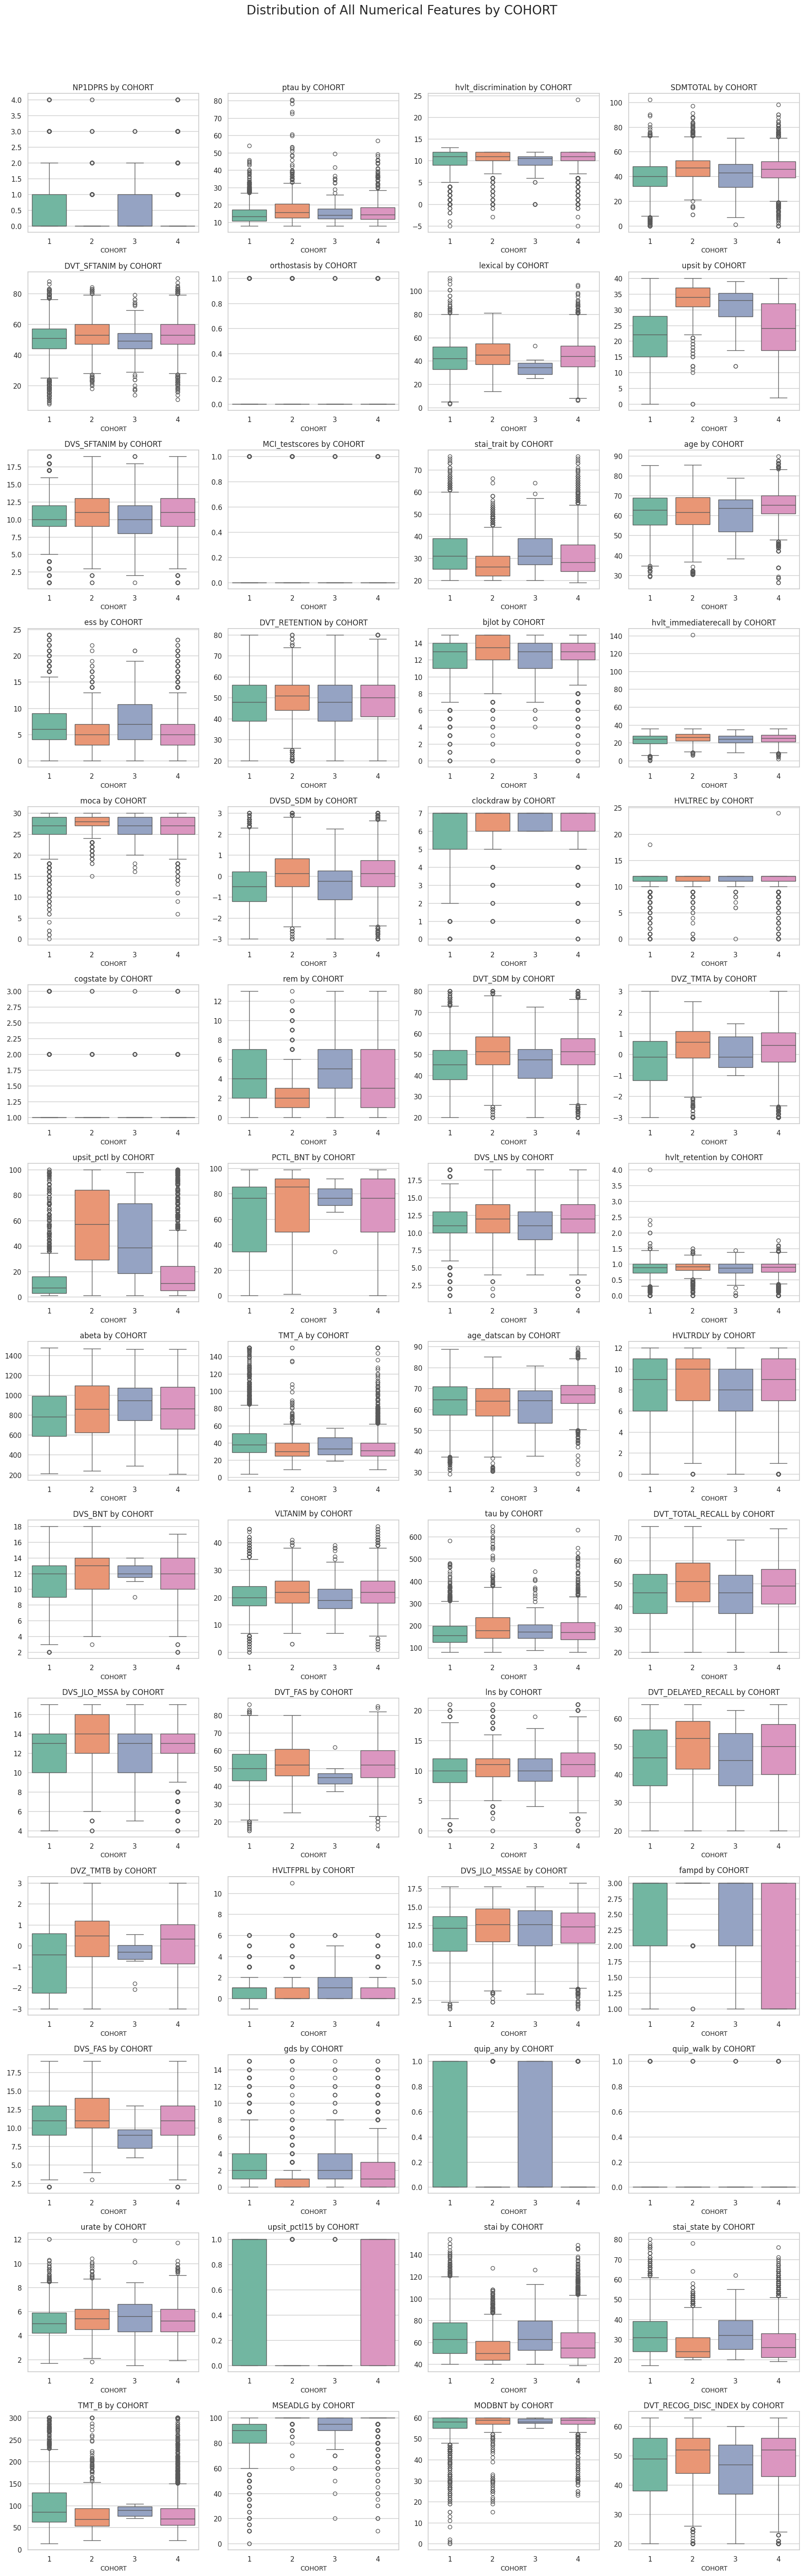

In [32]:
# --- 按 COHORT 绘制所有数值特征的箱线图 ---
print("--- 绘制所有数值特征的箱线图（按 COHORT 分组） ---")

# 1️⃣ 选择数值特征（与之前保持一致）
numeric_features = (
    df_v2.select_dtypes(include=np.number)
      .drop(columns=['PATNO', 'COHORT'])
      .columns
)

n_features = len(numeric_features)
print(f"检测到 {n_features} 个数值特征。")

# 2️⃣ 布局参数
n_cols = 4
n_rows = math.ceil(n_features / n_cols)

# 3️⃣ 创建子图
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.5 * n_cols, 4 * n_rows))
axes = axes.flatten()

# 4️⃣ 遍历每个特征并绘制箱线图
for i, feature in enumerate(numeric_features):
    sns.boxplot(
        x='COHORT', 
        y=feature, 
        data=df_v2, 
        ax=axes[i],
        hue='COHORT', 
        palette='Set2',
        legend=False
    )
    axes[i].set_title(f'{feature} by COHORT', fontsize=12)
    axes[i].set_xlabel('COHORT', fontsize=10)
    axes[i].set_ylabel('')

# 删除多余子图
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# 5️⃣ 总标题与布局
fig.suptitle('Distribution of All Numerical Features by COHORT', fontsize=20, y=1.02)
plt.tight_layout()
plt.show()


--- 特征相关性分析 ---
计算以下 15 个随机特征的相关性矩阵:
['quip_any' 'urate' 'fampd' 'DVZ_TMTA' 'stai_trait' 'gds' 'hvlt_retention'
 'moca' 'lexical' 'TMT_A' 'DVZ_TMTB' 'HVLTFPRL' 'DVT_RETENTION'
 'DVT_TOTAL_RECALL' 'VLTANIM']


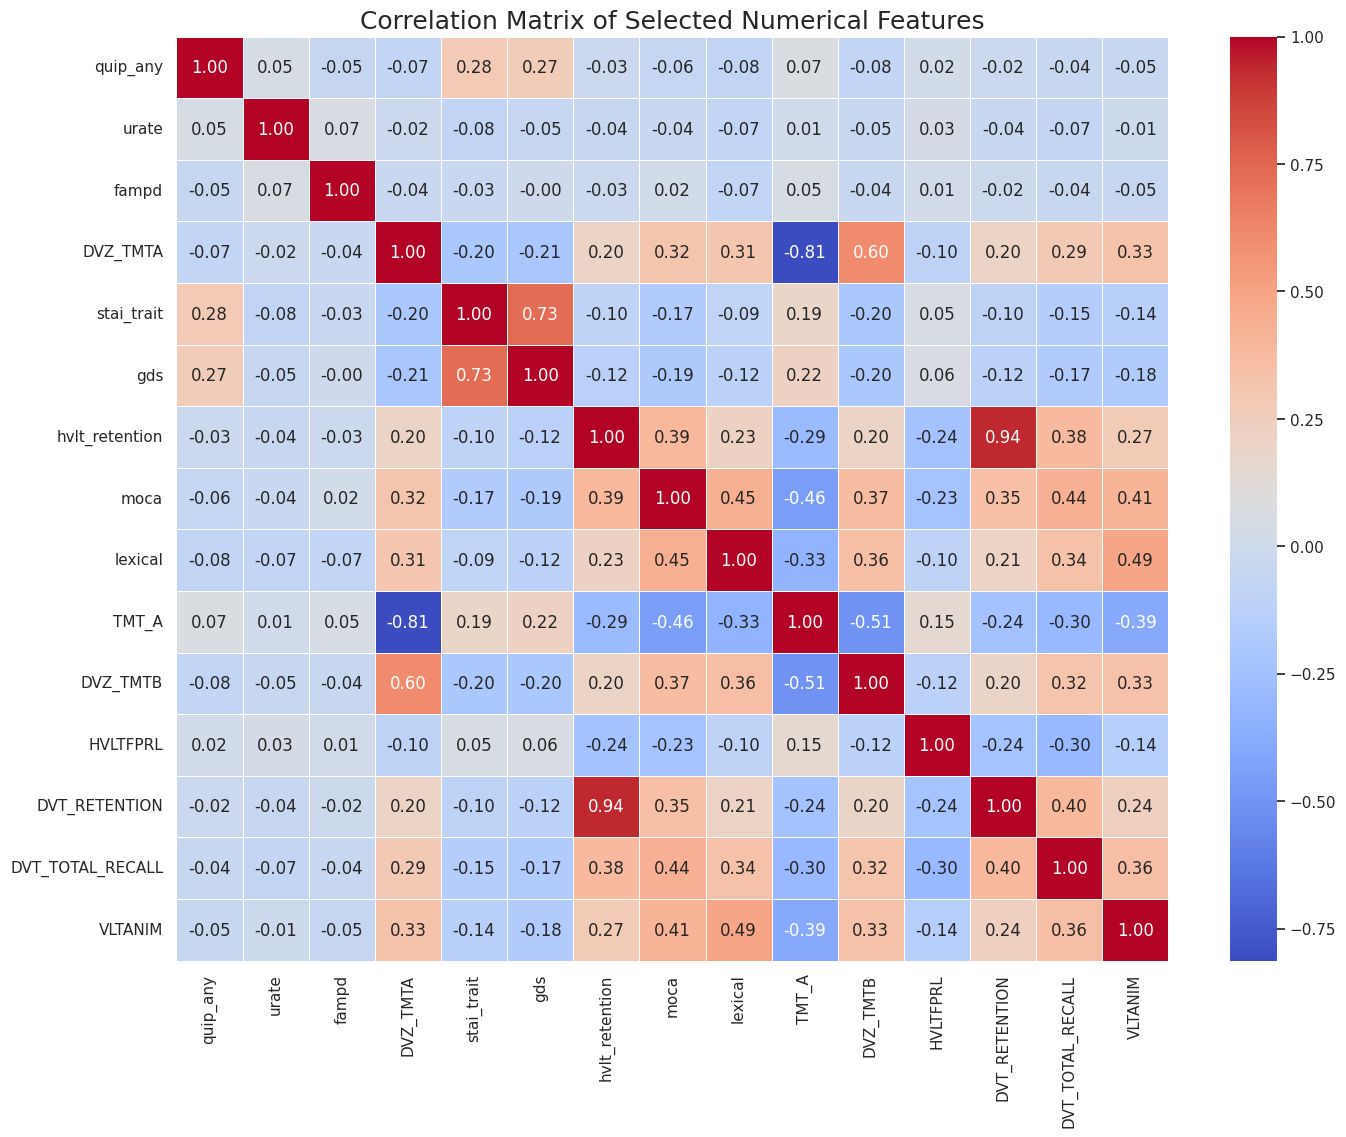

In [33]:
# --- 9. 特征相关性热力图 ---
print("--- 特征相关性分析 ---")

# 计算数值特征的相关矩阵
# 我们从numeric_features中随机选择一部分（例如15个）进行可视化，
# 因为50多个特征的热力图会过于密集，难以阅读。
if len(numeric_features) > 15:
    corr_features = np.random.choice(numeric_features, 15, replace=False)
else:
    corr_features = numeric_features

print(f"计算以下 {len(corr_features)} 个随机特征的相关性矩阵:")
print(corr_features)

correlation_matrix = df_v2[corr_features].corr()

# 绘制热力图
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Selected Numerical Features', fontsize=18)
plt.show()

